In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ====================================================
# 1. Imports and Setup
# ====================================================
import scipy.io
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ====================================================
# 2. Dataset Definition
# ====================================================
class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the .mat file
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # Process location group information
        # location_group is a 1x3 cell array: each cell contains the indices of stations in that group
        location_group = data['location_group']  # shape: (1, 3)
        location_ids = data['location_ids'].flatten()  # shape: (37,)
        num_stations = len(location_ids)  # should be 37

        # Create an array to store the group ID for each station
        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            # Each cell contains an array of station indices (MATLAB indices are 1-based)
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-based index
            group_ids[station_indices] = i + 1  # assign group number (1, 2, 3)

        self.group_ids = group_ids

        # Load training or testing data based on flag
        if train:
            X_data = data['X_tr']  # shape: (1, 423), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, 423)
        else:
            X_data = data['X_te']  # shape: (1, 282), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, 282)

        # Convert cell arrays into lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # Get input and target: X shape (37, 11), Y shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Build column vector of group IDs (shape: (37,) -> (37, 1))
        group_col = torch.tensor(self.group_ids, dtype=torch.float32).unsqueeze(1)
        # Concatenate group info to original features -> new shape (37, 12)
        x = torch.cat((x, group_col), dim=1)

        # Add channel dimension for CNN input -> final shape (1, 37, 12)
        x = x.unsqueeze(0)

        if self.transform:
            x = self.transform(x)

        return x, y

# ====================================================
# 3. Model Definition
# ====================================================
class LightWaterQualityCNN(nn.Module):
    def __init__(self):
        super(LightWaterQualityCNN, self).__init__()
        # Input shape: (batch_size, 1, 37, 12)
        # First convolutional block: 1 -> 16 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        # Second convolutional block: 16 -> 32 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        # Third convolutional block: 32 -> 48 channels (added layer)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(48)
        
        self.dropout2d = nn.Dropout2d(0.2)
        
        # After three conv layers, spatial dimensions remain 37 x 12
        self.flatten_dim = 48 * 37 * 12
        # Two fully connected layers: one hidden layer and output layer
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 37)

    def forward(self, x):
        # x: (batch_size, 1, 37, 12)
        x = F.relu(self.bn1(self.conv1(x)))  # -> (batch_size, 16, 37, 12)
        x = self.dropout2d(x)
        x = F.relu(self.bn2(self.conv2(x)))  # -> (batch_size, 32, 37, 12)
        x = self.dropout2d(x)
        x = F.relu(self.bn3(self.conv3(x)))  # -> (batch_size, 48, 37, 12)
        x = self.dropout2d(x)
        
        x = x.view(x.size(0), -1)  # flatten: (batch_size, 48*37*12)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)  # -> (batch_size, 37)
        return x

# ====================================================
# 4. Training and Evaluation Functions
# ====================================================
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_x, batch_y in pbar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.6f}")
    return running_loss / len(train_loader.dataset)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
    return running_loss / len(test_loader.dataset)

def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        # Get a random batch from the test set
        sample_x, sample_y = random.choice(list(test_loader))
        sample_x = sample_x.to(device)
        sample_y = sample_y.to(device)
        predictions = model(sample_x)
        
        # Convert predictions and true values to numpy arrays
        predictions_np = predictions.cpu().numpy()
        true_np = sample_y.cpu().numpy()
    
    # Print comparison for the first sample in the batch
    print("Comparison for the first sample in the batch:")
    for station_idx in range(true_np.shape[1]):
        print(f"Station {station_idx+1:2d}: True = {true_np[0, station_idx]:.4f}, Predicted = {predictions_np[0, station_idx]:.4f}")
    
    # Plot the true vs. predicted values for the first sample
    plt.figure(figsize=(10, 5))
    plt.plot(true_np[0], label="True", marker='o')
    plt.plot(predictions_np[0], label="Predicted", marker='x')
    plt.title("True vs Predicted Water Quality Values")
    plt.xlabel("Station Index")
    plt.ylabel("Water Quality (pH)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

class NRMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(NRMSELoss, self).__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        mse = torch.mean((y_true - y_pred) ** 2)
        rmse = torch.sqrt(mse + self.eps)
        # Normalizing by the mean absolute value (or you could use mean value if targets are positive)
        norm = torch.mean(torch.abs(y_true)) + self.eps
        return rmse / norm


In [2]:
# ====================================================
# 5. Main Training Loop
# ====================================================

# File path for the dataset
mat_file_path = 'water_dataset.mat'  # Replace with your actual file path

batch_size = 2

# Create dataset and DataLoader instances
train_dataset = WaterQualityDataset(mat_file_path, train=True)
test_dataset = WaterQualityDataset(mat_file_path, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss function, optimizer, and learning rate scheduler
model = LightWaterQualityCNN().to(device)

criterion = NRMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    scheduler.step(test_loss)
    
    # Get the current learning rate (assuming one parameter group)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, LR: {current_lr:.8f}")

C:\Users\75597\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 -- Train Loss: 0.78784675, Test Loss: 0.31782099, LR: 0.00100000


Epoch 2/10 -- Train Loss: 0.41921760, Test Loss: 0.33351665, LR: 0.00100000


Epoch 3/10 -- Train Loss: 0.29352752, Test Loss: 0.16803108, LR: 0.00100000


Epoch 4/10 -- Train Loss: 0.13458915, Test Loss: 0.04953815, LR: 0.00100000


Epoch 5/10 -- Train Loss: 0.03501025, Test Loss: 0.03392317, LR: 0.00100000


Epoch 6/10 -- Train Loss: 0.03419273, Test Loss: 0.03370032, LR: 0.00100000


Epoch 7/10 -- Train Loss: 0.02998749, Test Loss: 0.03359195, LR: 0.00100000


Epoch 8/10 -- Train Loss: 0.02987307, Test Loss: 0.03382733, LR: 0.00100000


Epoch 9/10 -- Train Loss: 0.02989340, Test Loss: 0.03381714, LR: 0.00100000


Epoch 10/10 -- Train Loss: 0.02992478, Test Loss: 0.03376277, LR: 0.00100000


Comparison for the first sample in the batch:
Station  1: True = 0.6759, Predicted = 0.6496
Station  2: True = 0.7130, Predicted = 0.6646
Station  3: True = 0.7130, Predicted = 0.6601
Station  4: True = 0.7130, Predicted = 0.6723
Station  5: True = 0.6944, Predicted = 0.6799
Station  6: True = 0.6852, Predicted = 0.6519
Station  7: True = 0.6852, Predicted = 0.6509
Station  8: True = 0.7222, Predicted = 0.6886
Station  9: True = 0.7222, Predicted = 0.7071
Station 10: True = 0.6296, Predicted = 0.6418
Station 11: True = 0.6574, Predicted = 0.6504
Station 12: True = 0.7037, Predicted = 0.6625
Station 13: True = 0.6481, Predicted = 0.6548
Station 14: True = 0.6574, Predicted = 0.6467
Station 15: True = 0.6389, Predicted = 0.6388
Station 16: True = 0.6852, Predicted = 0.6643
Station 17: True = 0.6389, Predicted = 0.6466
Station 18: True = 0.6759, Predicted = 0.6725
Station 19: True = 0.6759, Predicted = 0.6627
Station 20: True = 0.6481, Predicted = 0.6365
Station 21: True = 0.6481, Predict

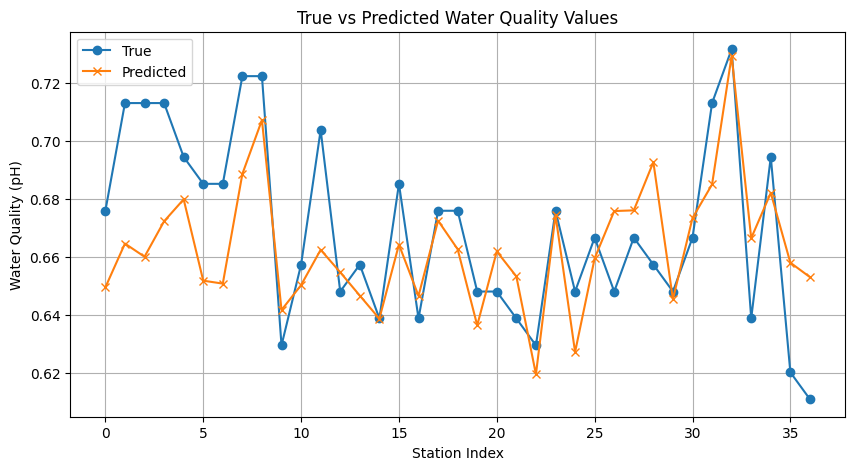

In [67]:

visualize_predictions(model, test_loader, device)